# K-Mean Clustering

**Overview**<br>
Online retail is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

we will be using the online retail transnational dataset to build a RFM Clustering and choose the best set of customers.

In [1]:
# Importing Libraries
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To scale our data
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

### Reading the Data Set

In [2]:
# reading Dataset
retail = pd.read_csv("Online+Retail+P.csv", sep = ',',encoding = "ISO-8859-1", header= 0)

# parse date
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format = "%d-%m-%Y %H:%M")


### Data quality check and cleaning

In [3]:
# Let's look up top 5 rows
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Sanity Check
retail.shape
retail.describe()
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
# Na Handling
retail.isnull().values.any()
retail.isnull().values.sum()
retail.isnull().sum()*100/retail.shape[0]

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [6]:
# dropping the na cells
order_wise = retail.dropna()

In [7]:
#Sanity check
order_wise.shape
order_wise.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Extracting R(Recency), F(Frequency), M(Monetary) columns from the data that we imported in

In [8]:
# RFM implementation

# Extracting amount by multiplying quantity and unit price and saving the data into amount variable.
amount = pd.DataFrame(order_wise.Quantity * order_wise.UnitPrice, columns = ["Amount"])
amount.head()

,Amount
0,15.30
1,20.34
2,22.00
3,20.34
4,20.34


### Monetary Value

In [9]:
#merging amount in order_wise
order_wise = pd.concat(objs = [order_wise, amount], axis = 1, ignore_index = False)

In [10]:
#Monetary Function
# Finding total amount spent per customer
monetary = order_wise.groupby("CustomerID").Amount.sum()
monetary = monetary.reset_index()
monetary.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


#### Frequency Value

In [11]:
# Frequency function
frequency = order_wise[['CustomerID', 'InvoiceNo']]

In [12]:
# Getting the count of orders made by each customer based on customer ID
k = frequency.groupby("CustomerID").InvoiceNo.count()
k = pd.DataFrame(k)
k = k.reset_index()
k.columns = ["CustomerID","Frequency"]
k.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


#### Merging Amount and Frequency columns

In [13]:
# creating master dataset
master = monetary.merge(k, on = "CustomerID", how = "inner")
master.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


### Recency Value

In [14]:
#Generating recency function

# Filtering data for customerid and invoice_date
recency = order_wise[['CustomerID','InvoiceDate']]

# Finding max data
maximum = max(recency.InvoiceDate)
maximum

Timestamp('2011-12-09 12:50:00')

In [15]:
# Adding one more day to the max data, so that the max data will have 1 as the difference and not zero.
maximum = maximum + pd.DateOffset(days=1)
recency['diff'] = maximum - recency.InvoiceDate
recency.head()

E:\Data Science\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,CustomerID,InvoiceDate,diff
0,17850.0,2010-12-01 08:26:00,374 days 04:24:00
1,17850.0,2010-12-01 08:26:00,374 days 04:24:00
2,17850.0,2010-12-01 08:26:00,374 days 04:24:00
3,17850.0,2010-12-01 08:26:00,374 days 04:24:00
4,17850.0,2010-12-01 08:26:00,374 days 04:24:00


In [16]:
# recency by Customer ID
a = recency.groupby('CustomerID')
a.diff.min()

CustomerID
12346.0   326 days 02:33:00
12347.0     2 days 20:58:00
12348.0    75 days 23:37:00
12349.0    19 days 02:59:00
12350.0   310 days 20:49:00
12352.0    36 days 22:13:00
12353.0   204 days 19:03:00
12354.0   232 days 23:39:00
12355.0   214 days 23:01:00
12356.0    23 days 04:10:00
12357.0    33 days 20:43:00
12358.0     2 days 02:24:00
12359.0     8 days 01:29:00
12360.0    52 days 21:28:00
12361.0   287 days 22:59:00
12362.0     3 days 21:10:00
12363.0   110 days 02:32:00
12364.0     8 days 02:28:00
12365.0   291 days 22:46:00
12367.0     4 days 20:02:00
12370.0    51 days 21:59:00
12371.0    45 days 02:34:00
12372.0    72 days 00:38:00
12373.0   311 days 23:40:00
12374.0    25 days 21:13:00
12375.0     3 days 01:23:00
12377.0   315 days 21:05:00
12378.0   130 days 02:16:00
12379.0    82 days 02:41:00
12380.0    22 days 01:23:00
                 ...       
18245.0     7 days 22:02:00
18246.0    24 days 01:01:00
18248.0   114 days 06:36:00
18249.0    17 days 21:43:00
18250.0  

In [17]:
# Dataframe merging by recency
df = pd.DataFrame(recency.groupby('CustomerID').diff.min())
df = df.reset_index()
df.columns = ["CustomerID","Recency"]
df.head()

,CustomerID,Recency
0,12346.0,326 days 02:33:00
1,12347.0,2 days 20:58:00
2,12348.0,75 days 23:37:00
3,12349.0,19 days 02:59:00
4,12350.0,310 days 20:49:00


### RFM combined DataFrame

In [18]:
# Combining all recency, frequency and monetary parameters
RFM = master.merge(df, on = "CustomerID")
RFM.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,326 days 02:33:00
1,12347.0,4310.00,182,2 days 20:58:00
2,12348.0,1797.24,31,75 days 23:37:00
3,12349.0,1757.55,73,19 days 02:59:00
4,12350.0,334.40,17,310 days 20:49:00


### Outlier Treatment

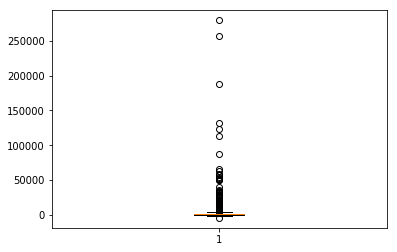

In [19]:
# outlier treatment for Amount
plt.boxplot(RFM.Amount)
Q1 = RFM.Amount.quantile(0.25)
Q3 = RFM.Amount.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Amount >= Q1 - 1.5*IQR) & (RFM.Amount <= Q3 + 1.5*IQR)]

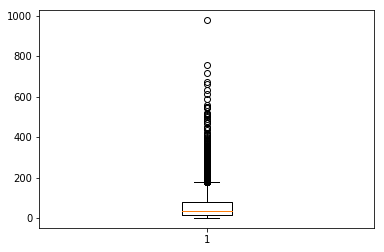

In [20]:
# outlier treatment for Frequency
plt.boxplot(RFM.Frequency)
Q1 = RFM.Frequency.quantile(0.25)
Q3 = RFM.Frequency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]

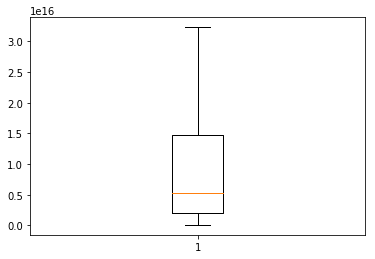

In [21]:
# outlier treatment for Recency
plt.boxplot(RFM.Recency)
Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]

In [22]:
RFM.head(20)

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,326 days 02:33:00
2,12348.0,1797.24,31,75 days 23:37:00
3,12349.0,1757.55,73,19 days 02:59:00
4,12350.0,334.40,17,310 days 20:49:00
5,12352.0,1545.41,95,36 days 22:13:00
6,12353.0,89.00,4,204 days 19:03:00
7,12354.0,1079.40,58,232 days 23:39:00
8,12355.0,459.40,13,214 days 23:01:00
9,12356.0,2811.43,59,23 days 04:10:00
11,12358.0,1168.06,19,2 days 02:24:00


### Scaling the RFM data

In [23]:
# standardise all parameters
RFM_norm1 = RFM.drop("CustomerID", axis=1)
RFM_norm1.Recency = RFM_norm1.Recency.dt.days

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
RFM_norm1 = standard_scaler.fit_transform(RFM_norm1)

E:\Data Science\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
E:\Data Science\Anaconda\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [24]:
RFM_norm1 = pd.DataFrame(RFM_norm1)
RFM_norm1.columns = ['Amount','Frequency','Recency']
RFM_norm1.head()

,Amount,Frequency,Recency
0,-1.041614,-1.070949,2.136422
1,1.385298,-0.375498,-0.282050
2,1.331702,0.631707,-0.821629
3,-0.590055,-0.711233,1.982257
4,1.045238,1.159290,-0.657828


## Hopkins Statistics :
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ... , 0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is be between {0.7, ... , 0.99}, it has a high tendency to cluster.


Some usefull links to understand Hopkins Statistics:
- [WikiPedia](https://en.wikipedia.org/wiki/Hopkins_statistic)
- [Article](http://www.sthda.com/english/articles/29-cluster-validation-essentials/95-assessing-clustering-tendency-essentials/)

In [25]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [26]:
hopkins(RFM_norm1)

0.8918397916708832

## K-Means with some K

In [27]:
# Kmeans with K=5
model_clus5 = KMeans(n_clusters = 5, max_iter=50)
model_clus5.fit(RFM_norm1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

## Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [28]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(RFM_norm1)
    sse_.append([k, silhouette_score(RFM_norm1, kmeans.labels_)])

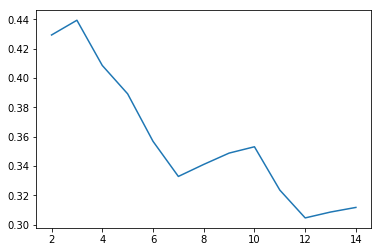

In [29]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

## Sum of Squared Distances

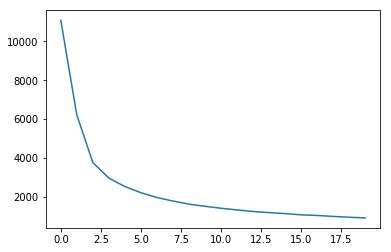

In [30]:
# sum of squared distances
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(RFM_norm1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

In [31]:
# analysis of clusters formed
RFM.index = pd.RangeIndex(len(RFM.index))
RFM_km = pd.concat([RFM, pd.Series(model_clus5.labels_)], axis=1)
RFM_km.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency', 'ClusterID']

RFM_km.Recency = RFM_km.Recency.dt.days
km_clusters_amount = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())

In [32]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.head()

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0,913.691366,114.125683,54.122951
1,1,356.193340,23.263696,57.818846
2,2,327.627693,20.598234,262.737307
3,3,2472.898046,117.600543,38.366848
4,4,1195.977443,53.688953,49.960756


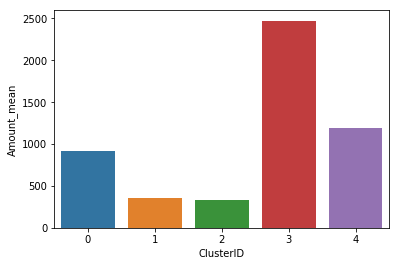

In [33]:
sns.barplot(x=df.ClusterID, y=df.Amount_mean)

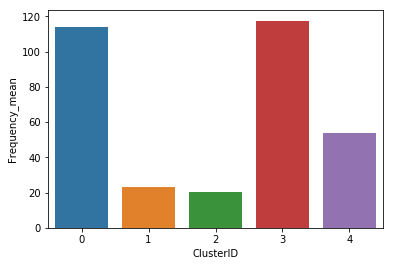

In [34]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

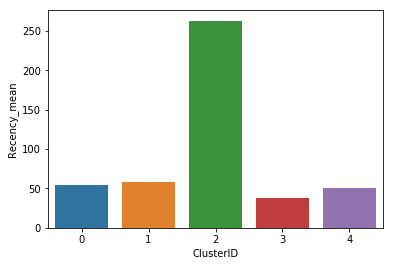

In [35]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)

## Heirarchical Clustering

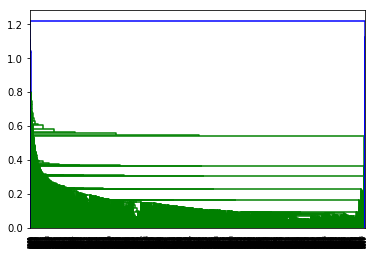

In [36]:
# heirarchical clustering
mergings = linkage(RFM_norm1, method = "single", metric='euclidean')
dendrogram(mergings)
plt.show()

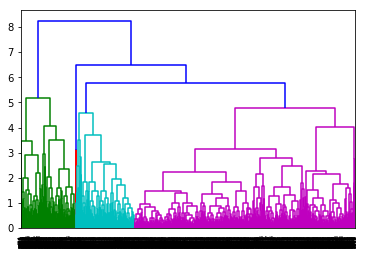

In [37]:
mergings = linkage(RFM_norm1, method = "complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [38]:
clusterCut = pd.Series(cut_tree(mergings, n_clusters = 5).reshape(-1,))
RFM_hc = pd.concat([RFM, clusterCut], axis=1)
RFM_hc.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency', 'ClusterID']

In [39]:
#summarise
RFM_hc.Recency = RFM_hc.Recency.dt.days
km_clusters_amount = 	pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency = 	pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = 	pd.DataFrame(RFM_hc.groupby(["ClusterID"]).Recency.mean())

In [40]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.head()

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0,401.831170,23.929069,131.066011
1,1,1787.153319,44.943966,38.547414
2,2,2324.569366,122.145889,34.856764
3,3,915.359751,89.739875,65.752336
4,4,-997.147143,6.142857,218.285714


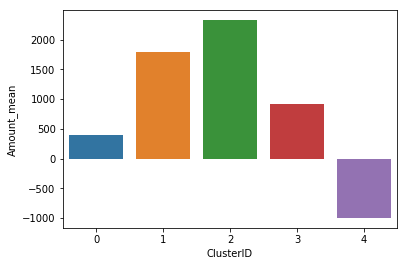

In [42]:
#plotting barplot
sns.barplot(x=df.ClusterID, y=df.Amount_mean)

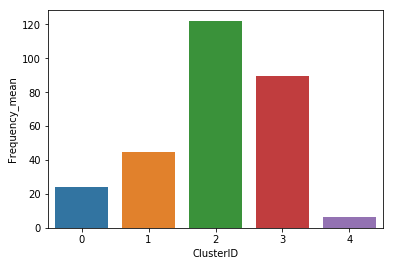

In [43]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

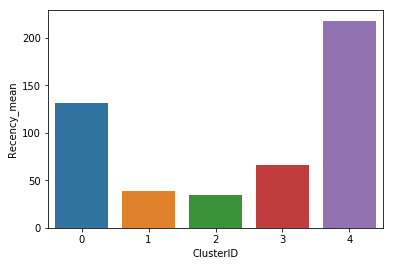

In [44]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)